In [4]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [5]:
df = pd.read_csv('./input/corpusfinal_word2vec.csv', sep=';')
df.shape

(1519, 2)

In [6]:
df.head()
df.isnull().sum()
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

Category    0
body        0
dtype: int64

In [7]:
nlp = spacy.load('fr', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

In [8]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    cleaned_up_txt = []
    
    if len(txt) > 2:
        return ' '.join(txt)

In [9]:
brief_cleaning = (re.sub("[^A-Za-záàâäãåçéèêëíìîïñóòôöõúùûüýÿæœÁÀÂÄÃÅÇÉÈÊËÍÌÎÏÑÓÒÔÖÕÚÙÛÜÝŸÆŒ']+", ' ', str(row)).lower() for row in df['body'])
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.47 mins


In [10]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(1497, 1)

In [11]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

INFO - 12:17:46: collecting all words and their counts
INFO - 12:17:46: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:17:46: collected 85564 word types from a corpus of 94202 words (unigram + bigrams) and 1497 sentences
INFO - 12:17:46: using 85564 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 12:17:46: source_vocab length 85564
INFO - 12:17:47: Phraser built with 20 phrasegrams


10617

In [12]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['l',
 'd',
 'produit',
 'faire',
 'falloir',
 'pouvoir',
 'consommation',
 'voiture',
 'permettre',
 'transport']

In [13]:
cores = multiprocessing.cpu_count()

In [14]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.init_sims(replace=True)

INFO - 12:17:48: collecting all words and their counts
INFO - 12:17:48: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:17:48: collected 10617 word types from a corpus of 93090 raw words and 1497 sentences
INFO - 12:17:48: Loading a fresh vocabulary
INFO - 12:17:48: effective_min_count=20 retains 980 unique words (9% of original 10617, drops 9637)
INFO - 12:17:48: effective_min_count=20 leaves 62710 word corpus (67% of original 93090, drops 30380)
INFO - 12:17:48: deleting the raw counts dictionary of 10617 items
INFO - 12:17:48: sample=6e-05 downsamples 980 most-common words
INFO - 12:17:48: downsampling leaves estimated 17656 word corpus (28.2% of prior 62710)
INFO - 12:17:48: estimated required memory for 980 words and 300 dimensions: 2842000 bytes
INFO - 12:17:48: resetting layer weights
INFO - 12:17:48: training model with 7 workers on 980 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 12:17:49: worker thread finis

Time to build vocab: 0.01 mins
Time to train the model: 0.17 mins


In [15]:
print(w2v_model.wv.most_similar(positive=["logement"]))


[('propriétaire', 0.9998371601104736), ('bâtiment', 0.9998363256454468), ('rénovation', 0.9998359680175781), ('isoler', 0.9998282790184021), ('isolation', 0.9998044371604919), ('maison', 0.9998027682304382), ('immobilier', 0.999788761138916), ('foncier', 0.9997738599777222), ('performance', 0.9997729659080505), ('énergétique', 0.9997681379318237)]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
def tsnescatterplot(model, word, list_names, dim):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    #reduc = PCA(n_components=50).fit_transform(arrays)
    reduc = PCA(n_components=dim).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [18]:
#tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'], 19)

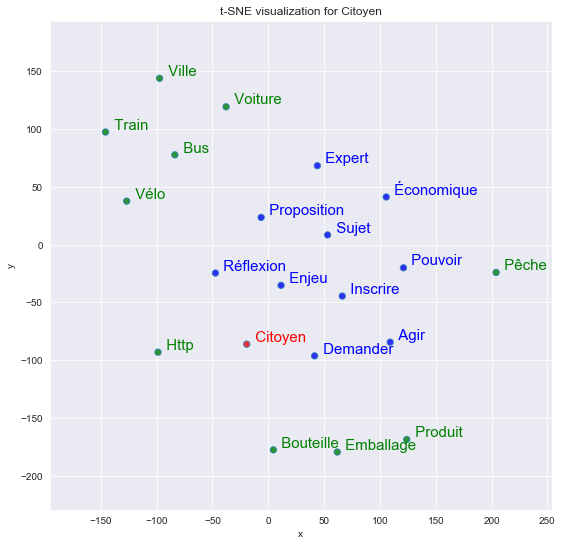

In [19]:
tsnescatterplot(w2v_model, 'citoyen', [i[0] for i in w2v_model.wv.most_similar(negative=["citoyen"])], 21)

In [20]:
#tsnescatterplot(w2v_model, 'capitalisme', [i[0] for i in w2v_model.wv.most_similar(negative=["capitalisme"])], 21)

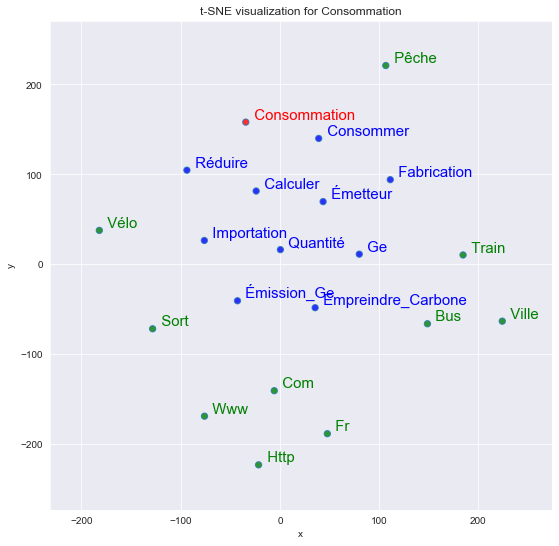

In [21]:
tsnescatterplot(w2v_model, 'consommation', [i[0] for i in w2v_model.wv.most_similar(negative=["consommation"])], 21)


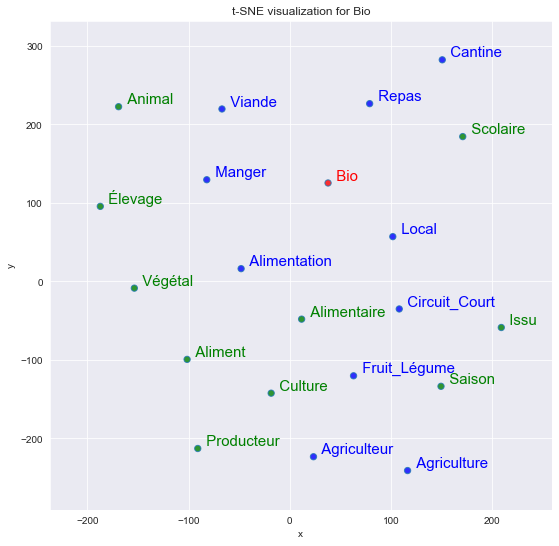

In [22]:
tsnescatterplot(w2v_model, "bio", [t[0] for t in w2v_model.wv.most_similar(positive=["bio"], topn=20)][10:], 21)


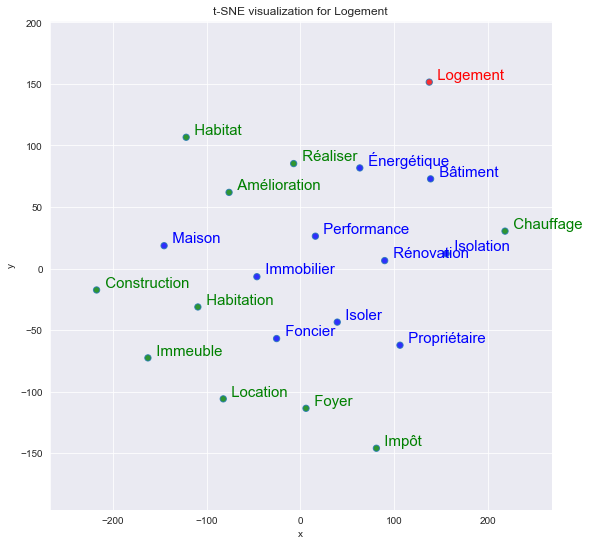

In [23]:
tsnescatterplot(w2v_model, "logement", [t[0] for t in w2v_model.wv.most_similar(positive=["logement"], topn=20)][10:], 21)

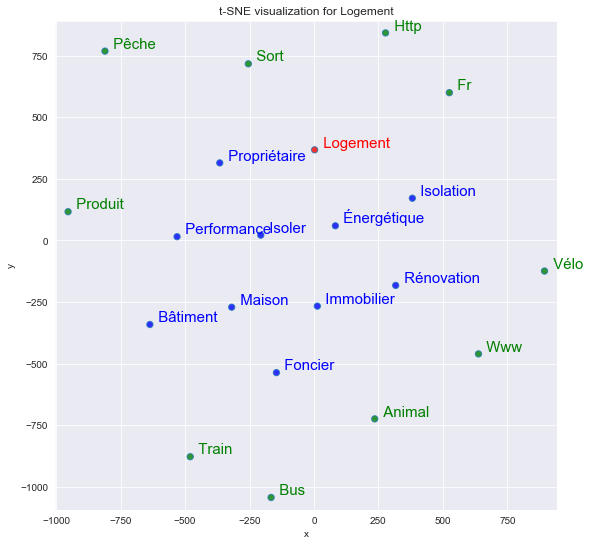

In [24]:
tsnescatterplot(w2v_model, 'logement', [i[0] for i in w2v_model.wv.most_similar(negative=["logement"])], 21)

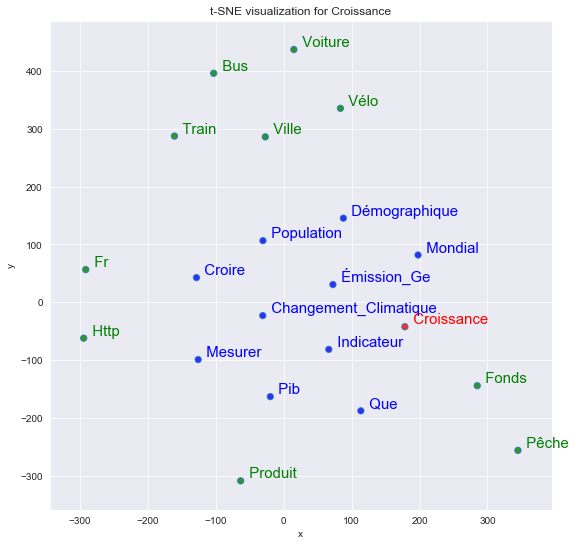

In [25]:
tsnescatterplot(w2v_model, 'croissance', [i[0] for i in w2v_model.wv.most_similar(negative=["croissance"])], 21)

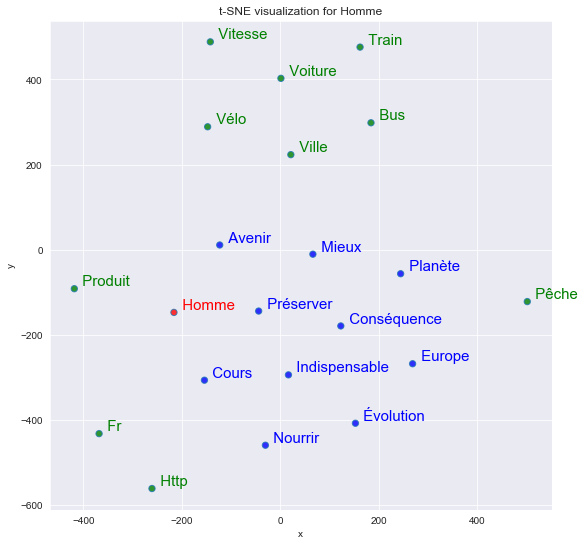

In [26]:
tsnescatterplot(w2v_model, 'homme', [i[0] for i in w2v_model.wv.most_similar(negative=["homme"])], 21)

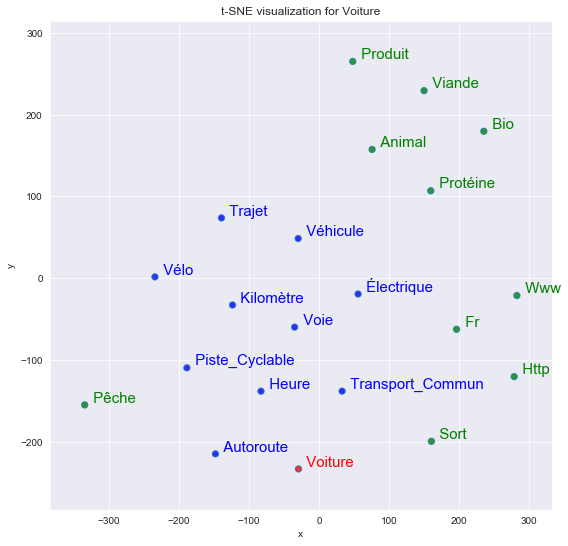

In [27]:
tsnescatterplot(w2v_model, 'voiture', [i[0] for i in w2v_model.wv.most_similar(negative=["voiture"])], 21)